In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution, percentage_outof_CI

In [3]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data) # y is unnormalised: good!

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

# Sliding Window
### Simple one-latent function model with SVGP

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

In [ ]:
def split_dataframe_by_position(df, splits):
    """
    Takes a dataframe and an integer of the number of splits to create.
    Returns a list of dataframes.
    """
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for split in range(splits):
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes

In [ ]:
splits = 121 # two month split
split_dataframes = split_dataframe_by_position(data, splits)

escape = 1

window_size = 5
for i in range(splits-window_size):
    print('--------------------')
    print(' SLIDING WINDOW ', i)
    print('--------------------')
    df = pd.DataFrame()

    for df_ind in range(window_size):
        if df_ind == 0:
            df = split_dataframes[i]
        else :
            df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

    whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
    pos, labels, yrs = get_xticks(whole_data)
    x_train, y_train = separate_data(df, normalised=True, weekdays=True)
    x_test, y_test = separate_data(split_dataframes[i+window_size], normalised=True, weekdays=True)

    #k = gpflow.kernels.Matern52() + gpflow.kernels.RBF()
    k = gpflow.kernels.Periodic(gpflow.kernels.RBF(), period=365.25) + gpflow.kernels.RBF()
    gp_split_fit_pred(x_train, y_train, k, title='Matern52 + RBF. --- Iteration ' + str(i), x_test=x_test, y_test=y_test, pos=pos, labels=labels, yrs=yrs, trainable=True)

    if (i==10) & (escape==1):
        break
    

In [4]:
def optimise_predict_model(model, M=3000):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    epochs = 50
    log_freq = 50

    for epoch in range(1, epochs + 1):
        optimisation_step()

        # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
        if epoch % log_freq == 0 and epoch > 0:
            print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    # predict
    mean_test, var_test = model.predict_f(x_test)
    print('Test')
    plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

    print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
    print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
    print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(model, fmt='notebook')

Epoch 20 - Loss:  4682.1905
Epoch 40 - Loss:  4557.5528
Epoch 60 - Loss:  4485.6346
Epoch 80 - Loss:  4436.1857
Epoch 100 - Loss:  4399.2020
Train


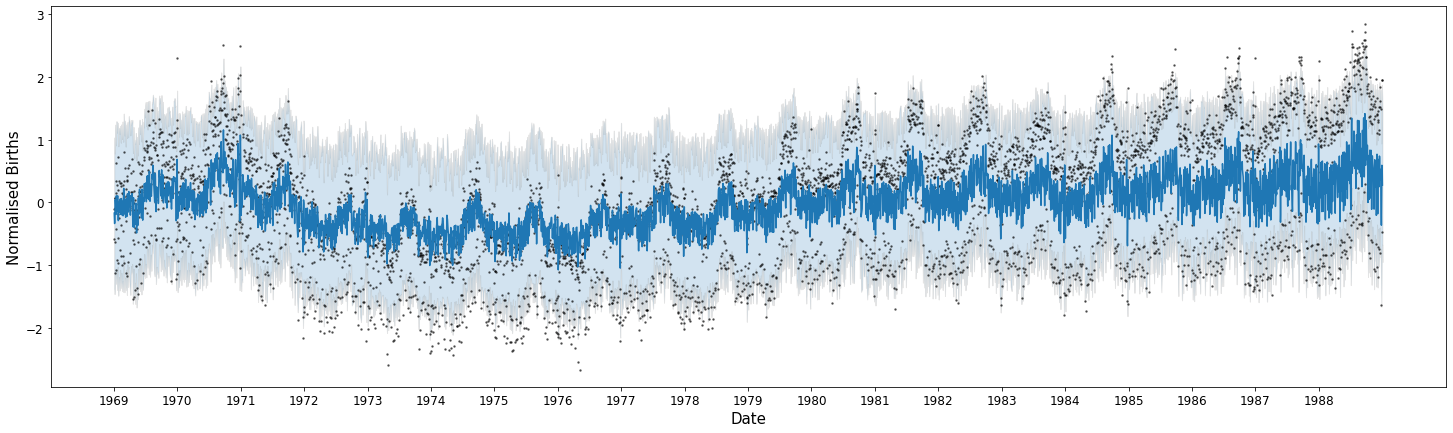

Test


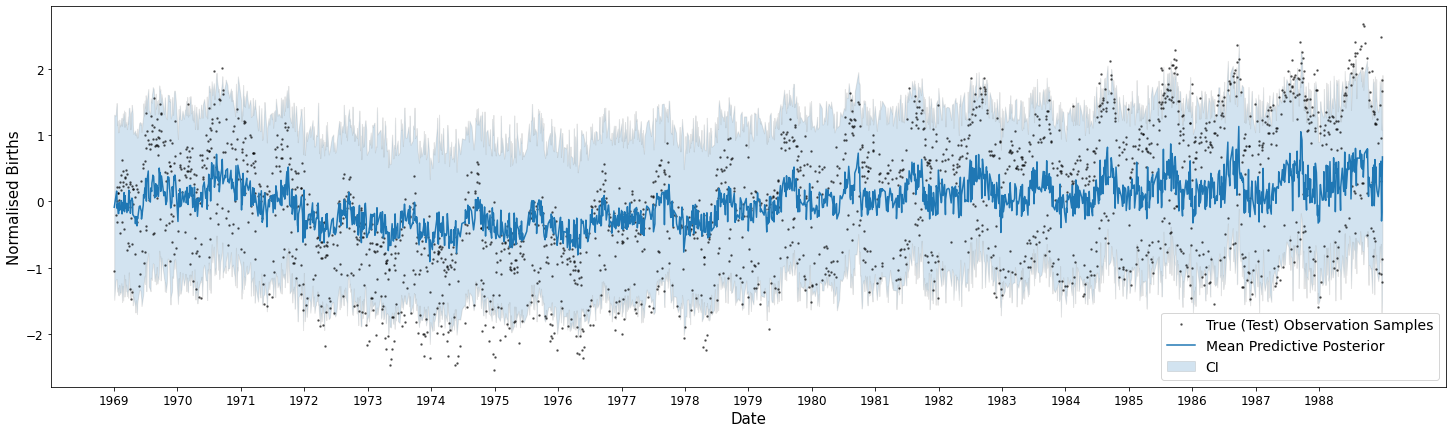

train ELBO, MSE, MAE:  -4397.202587573558 0.4402369687412963 0.5542282682161116
test ELBO, MSE, MAE:  -4961.5362556201835 0.724804026873664 0.7183912116470241
percentage out of CI (train, test):  6.630158419714453 11.861313868613138


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.6017711273375783
SVGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,1.5654835938362157
SVGP.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(3000, 1)",float64,[[2.51980967e+00...
SVGP.q_mu,Parameter,Identity,,False,"(3000, 1)",float64,[[-0.28184374...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 3000, 3000)",float64,"[[[0.74929501, 0., 0...."


In [7]:
kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
M = 3000
Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
set_trainable(model.likelihood.variance, False)
model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

train_data = (x_train, y_train)
loss_fn = model.training_loss_closure(train_data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        if epoch == 100:
            mean_train, var_train = model.predict_f(x_train)
            print('Train')
            plot_distribution(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

# predict
mean_test, var_test = model.predict_f(x_test)
print('Test')
plot_distribution(x_test, y_test, mean_test, var_test, pos, labels)

# evaluate
print('train ELBO, MSE, MAE: ', model.elbo((x_train,y_train)).numpy(), mean_squared_error(y_train, mean_train), mean_absolute_error(y_train, mean_train))
print('test ELBO, MSE, MAE: ', model.elbo((x_test,y_test)).numpy(), mean_squared_error(y_test, mean_test), mean_absolute_error(y_test, mean_test))
print('percentage out of CI (train, test): ', percentage_outof_CI(y_train, mean_train, var_train), percentage_outof_CI(y_test, mean_test, var_test))

print_summary(model, fmt='notebook')